# Подключаем необходимые библиотеки

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from pandas import datetime
from sklearn.metrics import r2_score

# Считываем наши данные

In [44]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,1,5,7,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Рассмотрим три отдельные категории: DRY EYE, ALERGY, VIT B и выделим из датасета три поднабора

In [45]:
dry_eye = data[data['PRODUCT_CATEGORY_LABEL']=='DRY EYE']

In [46]:
alergy = data[data['PRODUCT_CATEGORY_LABEL']=='ALERGY']

In [47]:
vit_b = data[data['PRODUCT_CATEGORY_LABEL']=='VIT B']

# Рассмотрим подробнее первый поднабор

In [48]:
dry_eye.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48186 entries, 1673 to 19461110
Data columns (total 11 columns):
WEEK                      48186 non-null object
PLN                       48186 non-null object
PLN_LABEL                 48186 non-null object
PRODUCT_CATEGORY          48186 non-null object
PRODUCT_CATEGORY_LABEL    48186 non-null object
OPSTUDY                   48186 non-null object
OPSTUDY_LABEL             48186 non-null object
ACTUAL                    48186 non-null object
BU                        47915 non-null object
SEG                       48186 non-null object
PROMO                     40513 non-null object
dtypes: object(11)
memory usage: 4.4+ MB


In [49]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
1673,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,150,Health/Wellness,A,N
1674,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,1113,Health/Wellness,C1,N
1675,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,295,Health/Wellness,B,N
1676,1160529,40000415307,REFRESH OPTIVE ADVANCED 10ML,186-002,DRY EYE,186,EYE/EAR,15,Health/Wellness,NoSegment-C,N
2474,1160529,40000684179,THERA TEARS LUB EYE DROPS 15ML,186-002,DRY EYE,186,EYE/EAR,153,Health/Wellness,A,N


## Удаляем ненужные столбцы 

In [50]:
dry_eye.drop(['BU', 'PRODUCT_CATEGORY_LABEL', 'PRODUCT_CATEGORY', 'OPSTUDY', 'OPSTUDY_LABEL'], axis=1, inplace=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Преобразуем признаки в необходимые типы

In [51]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [52]:
dry_eye['PLN'] = dry_eye['PLN'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [53]:
dry_eye['PLN_LABEL'] = dry_eye['PLN_LABEL'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [54]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: float(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
dry_eye['SEG'] = dry_eye['SEG'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
dry_eye['PROMO'] = dry_eye['PROMO'].apply(lambda x: str(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Преобразуем признак WEEK в datetime и создадим три новых колонки: YEAR, MONTH, DAY

In [57]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [58]:
dry_eye['WEEK'] = dry_eye['WEEK'].apply(lambda x: date_divide(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [59]:
dry_eye['WEEK'] = pd.to_datetime(dry_eye['WEEK'])

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
dry_eye['YEAR'] = [d.year for d in dry_eye['WEEK']]
dry_eye['MONTH'] = [d.month for d in dry_eye['WEEK']]
dry_eye['DAY'] = [d.day for d in dry_eye['WEEK']]

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

## Заменим значения признака SEG на числовые 

In [61]:
seg_dic = {'A':0, 'NoSegmen-A':1, 'B':2, 'NoSegment-B':3, 'C1':4, 'C2':5, 'C3':6, 'C4':7, 'NoSegment-C':8, 'NoBuisnessUnit':9}

In [62]:
dry_eye['SEG'] = dry_eye['SEG'].replace(seg_dic)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Если в датасете имеются отрицательные значения продаж, то заменим их на нулевые

In [63]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [64]:
dry_eye['ACTUAL'] = dry_eye['ACTUAL'].apply(lambda x: replace_negative(x))

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Заменим значения PROMO 'Y', 'N' на 1, 0

In [65]:
promo_dic = {'Y':1, 'N':0}

In [66]:
dry_eye['PROMO'] = dry_eye['PROMO'].replace(promo_dic)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
dry_eye.head()

,WEEK,PLN,PLN_LABEL,ACTUAL,SEG,PROMO,YEAR,MONTH,DAY
1673,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,150.0,0,0,2016,5,29
1674,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,1113.0,4,0,2016,5,29
1675,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,295.0,2,0,2016,5,29
1676,2016-05-29,40000415307,REFRESH OPTIVE ADVANCED 10ML,15.0,8,0,2016,5,29
2474,2016-05-29,40000684179,THERA TEARS LUB EYE DROPS 15ML,153.0,0,0,2016,5,29


## Выведем гистограму продаж

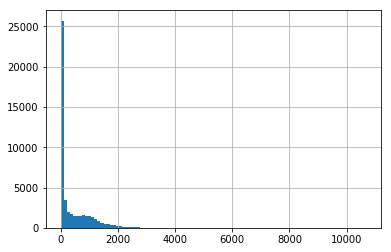

In [68]:
dry_eye['ACTUAL'].hist(bins=100);

## График количества продаж в каждый месяц по годам

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


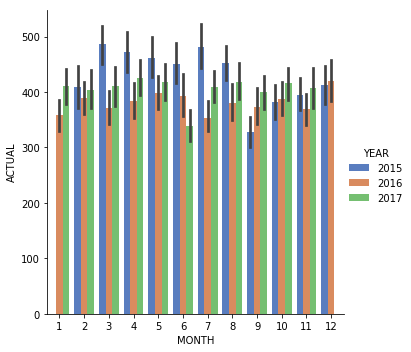

In [69]:
sns.catplot(x='MONTH', y='ACTUAL', hue='YEAR', data=dry_eye, kind='bar', palette='muted');

## Рассмотрим подробнее и попытаемся спрогнозировать продажи самого популярного продукта данной категории

In [70]:
dry_eye['PLN_LABEL'].value_counts()

BLINK GEL TEAR LUB EYE DROPS.34OZ    942
BLINK TEARS LUBRICATING DRPS .5OZ    935
BLINK TEARS LUBRICATING DROPS 1OZ    898
WALG ARTIFICIAL TEAR LBRCNT .5OZ     876
B&L SOOTHE LUB EYE DRPS .02OZ 28S    849
VISINE TEARS FOR DRY EYES    .5OZ    838
VISINE TEARS L/LST RLF DRYEYE.5OZ    826
SOOTHE HYDRATION DRY EYE DROP.5OZ    823
WALG LUB E DRP SNGL USE .01OZ 30S    819
SYSTANE ULT HIGH PERFORMANC .33OZ    797
WALG SODIUM CHLR OPTH ONT 5%.13OZ    785
SYSTANE LUB EYE DRP          .5OZ    782
B&L SOOTHE XP                15ML    779
SYSTANE BLNC LBRCNT EYE DROP.33OZ    776
SYSTANE PM LUBE EYE OINTMENT.12OZ    763
SYSTANE ULTRA            .33OZ 2S    753
WALG LUB E DRP SNGL USE .01OZ 70S    751
SYSTANE BALANCE EYE DROP .33OZ 2S    750
SIMILASAN E/DROP D/EYE 30014.33OZ    747
SIMILASAN CMPLT E RLF DRPS .33OZ     741
WALGREENS MURO 128 DROPS    .500Z    736
WALG ULT LUB EYEDRP VIAL .01OZ25S    726
SYSTANE LUB EYE DRP          30ML    721
SYSTANE ULTRA POCKET PACK.14OZ 2S    719
SYSTANE GEL DROP

In [71]:
first_item = dry_eye[dry_eye['PLN_LABEL']=='BLINK GEL TEAR LUB EYE DROPS.34OZ']

In [75]:
first_item.drop(['PLN_LABEL', 'PLN'], axis=1, inplace=True)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [72]:
first_item['WEEK'].value_counts()

2017-07-09    14
2017-05-28     8
2016-09-11     8
2016-10-09     8
2017-05-14     8
2017-03-12     8
2016-07-24     8
2016-11-06     8
2015-12-06     8
2016-04-17     8
2015-09-27     8
2017-02-12     8
2016-06-26     8
2015-11-08     8
2015-10-25     8
2016-06-12     8
2017-01-29     8
2017-06-04     8
2015-11-22     8
2016-07-10     8
2017-02-26     8
2017-04-30     8
2016-01-24     8
2017-03-26     8
2015-11-01     8
2016-11-13     8
2015-09-06     8
2016-04-24     8
2017-07-30     8
2015-10-04     8
              ..
2015-07-26     4
2015-08-23     4
2016-05-08     4
2015-03-01     4
2015-03-29     4
2015-04-26     4
2017-11-05     4
2015-05-24     4
2015-06-21     4
2016-02-07     4
2015-04-05     4
2017-08-20     4
2016-03-27     4
2017-01-01     4
2015-02-15     4
2016-05-22     4
2017-01-08     4
2015-03-15     4
2015-04-12     4
2015-05-10     4
2017-11-19     4
2015-06-07     4
2015-07-05     4
2016-02-21     4
2015-08-02     4
2016-03-20     4
2015-08-30     4
2015-02-08    

### Как видно выше недели повторяютя, сделаем так, чтобы на каждую конкретную неделю была только одна запись, для этого сложим все значения продаж для каждых повторяющихся недель. Также если хотя бы в одной из повторяющихся недель товар был на акции, то считаем, что и в "суммированной" недели он тоже будет на акции

In [94]:
first_item['PROMO'].value_counts()

0      460
1      362
nan    120
Name: PROMO, dtype: int64

In [105]:
weeks = np.unique(first_item['WEEK'].values)
sums = []
promos = []
indexes = first_item.index

In [106]:
for w in weeks:
    s = 0
    promo = 0
    for i in indexes:
        if first_item.at[i, 'WEEK']==w:
            s=s+first_item.at[i, 'ACTUAL']
            if first_item.at[i, 'PROMO']==1:
                promo = 1
    sums.append(s)
    promos.append(promo)

In [109]:
first_item1 = pd.DataFrame({'WEEK': weeks, 'ACTUAL': sums, 'PROMO': promos})

## Для составления прогноза воспользуемся моделью временных рядов ARIMA

### Ограничимся только двумя признаками: WEEK и ACTUAL 

In [113]:
first = first_item1[['WEEK', 'ACTUAL']].copy()

In [114]:
first.set_index('WEEK', inplace=True)

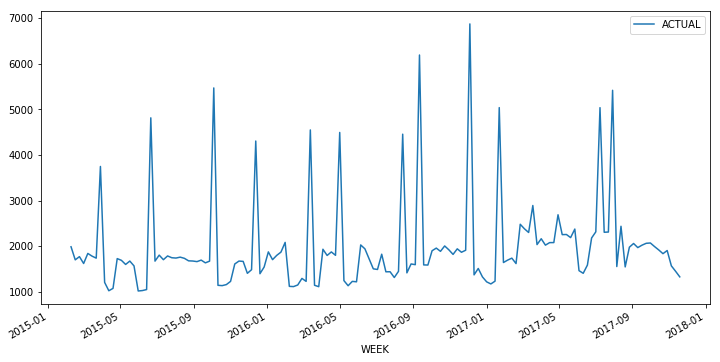

In [115]:
first.plot(figsize=(12, 6));

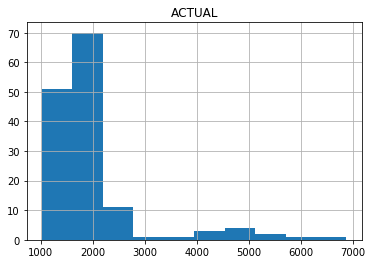

In [116]:
first.hist();

In [117]:
first.std()/first.mean()

ACTUAL    0.514481
dtype: float64

In [118]:
sp.stats.normaltest(first)

NormaltestResult(statistic=array([100.59806112]), pvalue=array([1.43023889e-22]))

In [122]:
sm.tsa.adfuller(first['ACTUAL'])

(-12.630353423663642,
 1.5095860676700053e-23,
 0,
 144,
 {'1%': -3.476597917537401,
  '5%': -2.8818291230495543,
  '10%': -2.5775887982253085},
 2180.4555049303044)

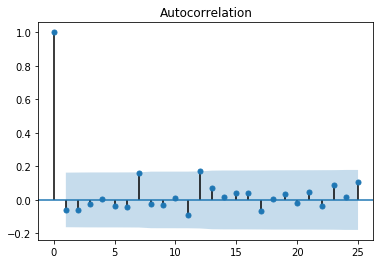

In [124]:
sm.graphics.tsa.plot_acf(first.values.squeeze(), lags=25);

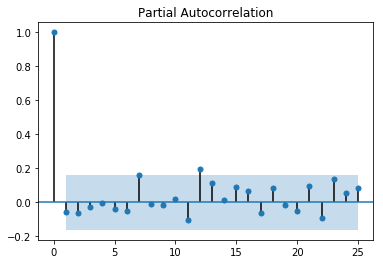

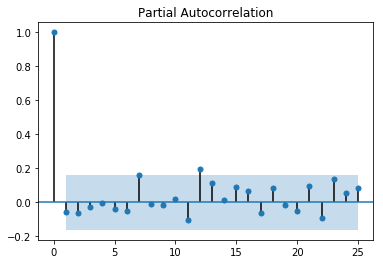

In [125]:
sm.graphics.tsa.plot_pacf(first, lags=25)

In [126]:
p = 1
q = 1
d = 1

In [134]:
train = first[:'2017-01-01']

In [135]:
arima_model = sm.tsa.ARIMA(train, order=(1, 1, 1)).fit(full_output=True, disp=0)

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [136]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ACTUAL   No. Observations:                   98
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -823.217
Method:                       css-mle   S.D. of innovations           1050.150
Date:                Thu, 17 Jan 2019   AIC                           1654.433
Time:                        12:24:34   BIC                           1664.773
Sample:                             1   HQIC                          1658.616
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.2257      3.343      1.264      0.209      -2.327      10.778
ar.L1.D.ACTUAL    -0.1082      0.101     -1.075      0.285      -0.305       0.089
ma.L1.D.ACTUAL    -1.0000      0.028    -36.002      0.000      -1.054      -0.946
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -9.2412           +0.0000j            9.2412            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [148]:
prediction = arima_model.predict(start=99, end=140, typ='levels')

C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
C:\Users\Anton.Lahunou\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [152]:
r2_score(first[99:141], prediction)

-0.00906904886341442

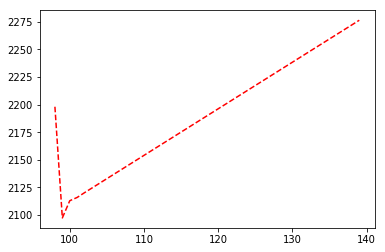

In [154]:
#first.plot(figsize=(12,6))
prediction.plot(style='r--')